In [1]:
import re

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from umap import UMAP

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.style.use("publication")

In [2]:
df = pd.read_pickle("../../data/interim/tmc1_table_vecs.pkl")

In [3]:
df = df.loc[df["Formula"] != "H2"]

df.reset_index(inplace=True, drop=True)

In [5]:
df["Column density (cm^-2)"] *= 1e-11

In [6]:
vectors = np.vstack(df["Vecs"].to_numpy())

In [7]:
manifold_model = UMAP(n_neighbors=15, min_dist=0.1, random_state=42, metric="cosine")

In [8]:
projection = manifold_model.fit_transform(vectors)

In [9]:
projection.shape

(82, 2)

In [10]:
df["Category"] = 0

In [11]:
df.loc[df["SMILES"].str.contains("N"), "Category"] = 1

In [12]:
df.loc[df["Formula"].str.contains("O"), "Category"] = 2

In [13]:
df.loc[df["Formula"].str.contains("S"), "Category"] = 3

In [14]:
df.iloc[[3, 4]].loc["Category"] = 4

/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
colors = ["#8361b3",
"#6da55b",
"#b74861",
"#c1803c"]

color_dict = {key: colors[key] for key in range(4)}

In [16]:
df["Color"] = df["Category"].map(color_dict)

In [17]:
labels = ["Hydrocarbon", "Nitrogen", "Oxygen", "Sulfur"]
label_dict = {key: labels[key] for key in range(len(labels))}

In [18]:
df["Label"] = df["Category"].map(label_dict)

In [19]:
polyynes = [f"HC{n}N" for n in range(3, 13, 2)]

In [20]:
polyyne_indices = df.loc[df["Formula"].isin(polyynes)].index

In [21]:
# skip out on the first cyanonaphthalene because it's big
big = df.loc[df["Formula"].isin(["C11H7N", "C5H5CN", "C6H5CN"])].iloc[[0, 2, 4]]

In [22]:
sulfurs = df.loc[(df["Category"] == 3) & (df["Molecule"].isin(["Carbon monosulfide", "Dicarbon monosulfide", "Thioformaldehyde"]))]

In [23]:
cyanides = df.loc[(df["Category"] == 1) & (df["Molecule"].isin(["Methyl cyanide", "Cyanomethyl radical", "2-cyanoethylidyl radical", "Vinylcyanide"]))]

## Polynomial fit to the projection

In [24]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [25]:
poly_model = make_pipeline(PolynomialFeatures(degree=2), Ridge())
poly_model.fit(projection[:,0][:,None], projection[:,1])

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge())])

In [26]:
x = np.linspace(projection[:,0].min() - 0.5, projection[:,0].max() + 0.5, 1000)
y = poly_model.predict(x[:,None])

In [27]:
def reformat_chemical_formula(formula: str) -> str:
    # this regex looks for sequential digits
    numerals = re.compile("\d{1,}")
    charges = re.compile("\d?[\+\-]")
    # use set to look at only unique entries to prevent replacing twice
    for number in set(numerals.findall(formula)):
        formula = formula.replace(number, "$_{" + number + "}$")
    for sign in set(charges.findall(formula)):
        formula = formula.replace(sign, "$^" + sign + "$")
    return formula

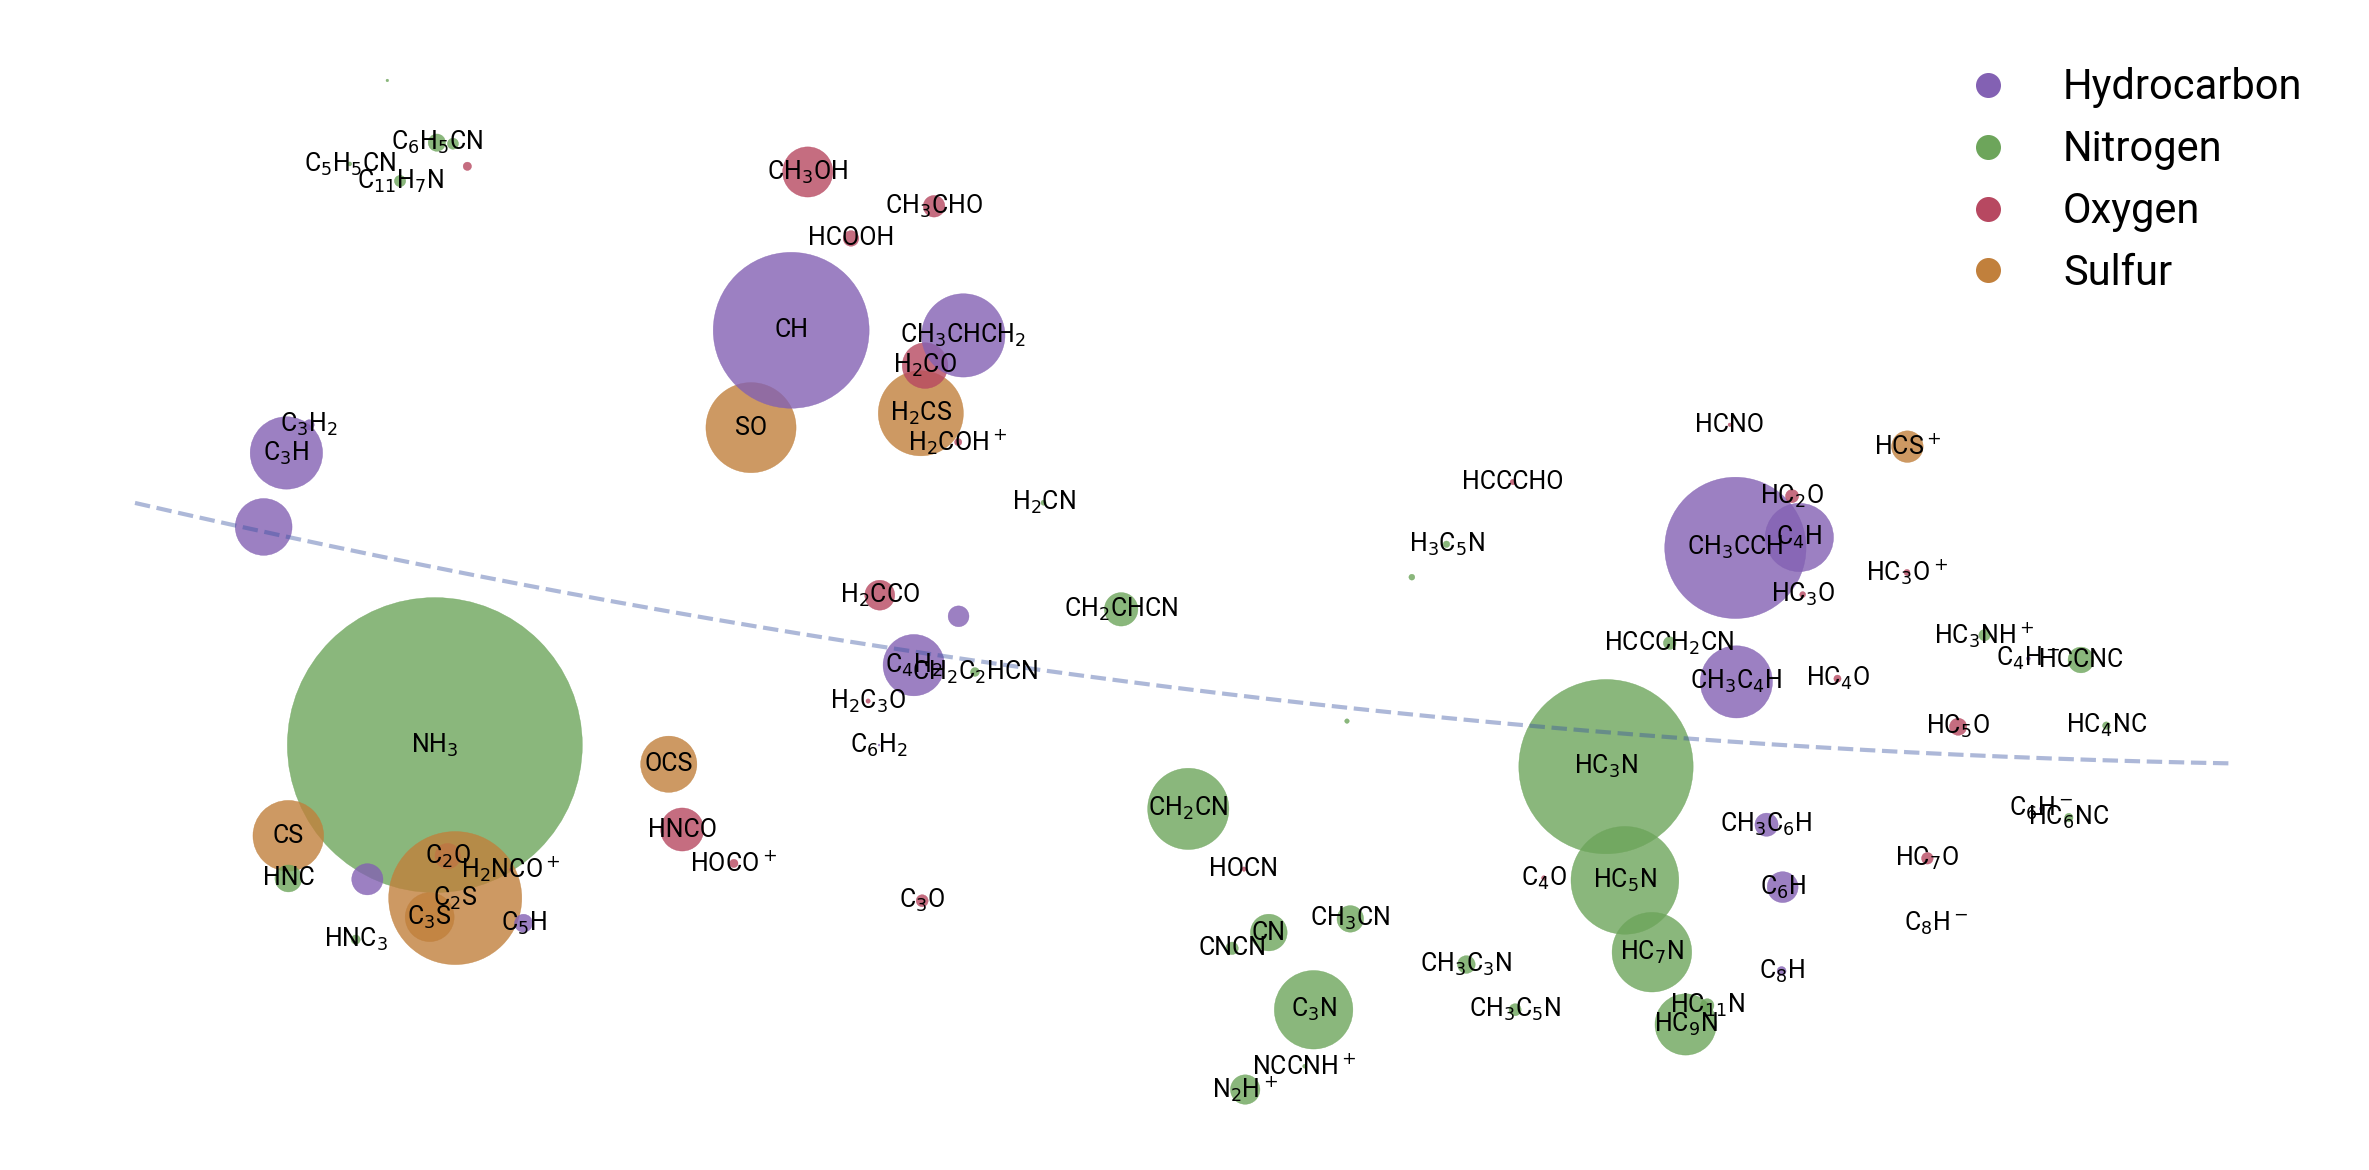

In [28]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(x, y, alpha=0.4, ls="--")
ax.scatter(projection[:,0], projection[:,1], s=df["Column density (cm^-2)"], alpha=0.8, lw=0.1, c=df["Color"])

done = list()

for index, row in df.iterrows():
    formula = row["Formula"]
    formatted = reformat_chemical_formula(formula)
    if formula not in done:
        ax.text(projection[index,0], projection[index, 1], formatted, horizontalalignment="center", verticalalignment="center", fontsize=6.)
        done.append(formula)

legend_elements = [
    Line2D([0], [0], marker="o", lw=0., color=colors[index], label=labels[index]) for index in range(4)
]
ax.legend(handles=legend_elements)
    
ax.set(xticks=[], yticks=[])
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

# fig.savefig("umap_tmc1_viz.png", dpi=300, transparent=True)
fig.savefig("umap_tmc1_viz_alllabel.pdf", dpi=100)